In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from timm.models import create_model
import vision_transformer as vits

import modeling_pretrain


# ------------------------------
#   1) Model & Processor Setup
# ------------------------------

def load_model_and_transform(model_type="dinov2", ckpt_path=None):
    """
    Loads the requested model and returns both:
      - model (nn.Module), set to eval mode
      - transform_fn (callable) to convert a PIL image into the correct input for the model

    Note: For the Hugging Face-based models (DINOv2, CLIP, EsViT),
    we wrap the HF processor in a function that returns a torch.Tensor.
    For SwAV (from TIMM), we use a standard torchvision transform pipeline.
    """
    model_type = model_type.lower()

    if model_type == "dinov2":
        from transformers import Dinov2Model, AutoImageProcessor
        model = Dinov2Model.from_pretrained("facebook/dinov2-base")
        processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

        def transform_fn(pil_img: Image.Image):
            # Convert PIL Image -> pixel_values: [3, H, W]
            inputs = processor(images=pil_img, return_tensors="pt")
            return inputs["pixel_values"].squeeze(0)
        
    elif "dino_" in model_type:
        
        arch = "vit_small"
        arch = "resnet50"
        arch = model_type.split("_")[1]
        checkpoint_key = 'teacher'
        
        if arch == "vit_small":
            pretrained_weights = '/home/mmr/code/SSL/dino/save/checkpoint0400.pth'
            # pretrained_weights = '/home/mmr/code/SSL/dino/save_6k/checkpoint0280.pth'
            patch_size = 16
            model = vits.__dict__[arch](patch_size=patch_size, num_classes=0)
            print(f"Model {arch} {patch_size}x{patch_size} built.")
        elif arch == "resnet50":
            import torchvision.models as torchvision_models
            import torch.nn as nn
            pretrained_weights = '/home/mmr/code/SSL/dino/save/dino_resnet50/checkpoint0260.pth'
            model = torchvision_models.__dict__[arch](num_classes=0)
            model.fc = nn.Identity()
            patch_size = -1
        
        model.cuda()
        load_pretrained_weights(model, pretrained_weights, checkpoint_key, arch, patch_size)
        
        transform_compose = transforms.Compose([
            # transforms.Resize(256, interpolation=3),
            # transforms.CenterCrop(224),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        def transform_fn(pil_img: Image.Image):
            # Convert PIL Image -> pixel_values: [3, H, W]
            return transform_compose(pil_img)
        
    elif "beitv2" in model_type:
        import torch
        # Load Pre-trained Model
        
        model = create_model(
            # 'beit_base_patch16_64_8k_vocab_cls_pt',
            # 'beit_tiny_patch16_64_8k_vocab_cls_pt',
            'beit_base_patch16_224_8k_vocab_cls_pt',
            pretrained=False,
            drop_path_rate=0,
            drop_block_rate=None,
            use_shared_rel_pos_bias=True,
            use_abs_pos_emb=False,
            init_values=0.1,
            vocab_size=8192,
            early_layers=9,
            # early_layers=3,
            head_layers=2,
            shared_lm_head=True,
        )
        # print(torch)
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        # checkpoint = torch.load('/home/murong/code/SSL/unilm/beit2/save/beit_base_patch16_224_8k_vocab_animal10n_pretrain_good/checkpoint.pth', map_location='cpu')
        # checkpoint = torch.load('/home/mmr/code/SSL/unilm/beit2/save/constrastive_finetuned_subtest/checkpoint.pth', map_location='cpu') # pos0.2 contrastive finetuning using influence ce clean
        # checkpoint = torch.load('/home/mmr/code/SSL/unilm/beit2/save/constrastive_finetuned_subtest/checkpoint.pth', map_location='cpu') # pos0.5 contrastive finetuning using influence ce clean
        # checkpoint = torch.load('/home/mmr/code/SSL/unilm/beit2/save/constrastive_finetuned_beitv2_pos05/checkpoint.pth', map_location='cpu')
        # checkpoint = torch.load('/home/mmr/code/XAI/UDA-pytorch_mod/temp_model/beitv2_finetune.pth', map_location='cpu')
        checkpoint = torch.load(ckpt_path, map_location='cpu')
        state_dict = checkpoint.get('model', checkpoint)
        model.load_state_dict(state_dict, strict=False)
        # Remove classification head (if necessary)
        model.head = torch.nn.Identity()

        # def extract_features_beitv2(model, dataloader, device='cuda'):
        #     features = []
        #     with torch.no_grad():
        #         for images, _ in tqdm(dataloader, total=len(dataloader)):  # Assuming dataloader returns (image, label)
        #             images = images.to(device)
        #             bool_masked_pos = torch.zeros((images.shape[0], 196), dtype=torch.bool).to(images.device)
        #             embeddings, _ = model.forward_features(images, bool_masked_pos)  # Extract features
        #             cls_token_embedding = embeddings[:, 0]  # Global embedding
        #             # print(cls_token_embedding)
        #             features.append(cls_token_embedding.cpu())
        #     return torch.cat(features, dim=0)
        
        transform_compose=transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
        def transform_fn(pil_img: Image.Image):
            return transform_compose(pil_img)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    model.eval()
    return model, transform_fn


def get_image_features(images: torch.Tensor, model: nn.Module, model_type: str):
    """
    Forward pass to extract features for each model type.
    """
    with torch.no_grad():
        if model_type == "dinov2":
            outputs = model(pixel_values=images)
            feats = outputs.pooler_output  # [batch_size, hidden_dim]
        elif 'dino_' in model_type:
            feats = model(images)
        elif "beitv2" in model_type:    
            bool_masked_pos = torch.zeros((images.shape[0], 196), dtype=torch.bool).to(images.device)
            embeddings, _ = model.forward_features(images, bool_masked_pos)  # Extract features
            feats = embeddings[:, 0]  # Global embedding
        else:
            raise ValueError(f"Unknown model type: {model_type}")
    return feats


# -----------------------------------
#   2) Original Dataset Definitions
# -----------------------------------
import os
import random
import pickle
import numpy as np

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

def generate_symmetric_noise(original_labels, num_classes, noise_ratio):
    """
    Given original labels, for a fraction (noise_ratio) of them,
    replace the label with a random *different* label among [0..num_classes-1].
    """
    labels = np.array(original_labels, dtype=np.int64)
    n_samples = len(labels)
    n_noisy = int(noise_ratio * n_samples)

    noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
    for idx in noisy_indices:
        current_label = labels[idx]
        # Possible new labels are all classes except the current one
        noisy_label_list = list(range(num_classes))
        noisy_label_list.remove(current_label)
        new_label = np.random.choice(noisy_label_list)
        labels[idx] = new_label

    return labels.tolist(), noisy_indices

def generate_asymmetric_noise(original_labels, noise_ratio, mapping):
    """
    Given original labels, for a fraction (noise_ratio) of them,
    replace the label with a specific new label according to `mapping`.
    
    Example of a mapping for CIFAR-10 could be:
        {0:0, 1:1, 2:0, 3:5, 4:7, 5:3, 6:6, 7:4, 8:8, 9:1}
    which means:
       2->0, 3->5, 4->7, 5->3, 7->4, 9->1, 
    and classes not in the mapping remain the same or map to themselves.
    
    The fraction of labels that get flipped from old_label -> mapping[old_label]
    is controlled by `noise_ratio`.
    """
    labels = np.array(original_labels, dtype=np.int64)
    n_samples = len(labels)
    n_noisy = int(noise_ratio * n_samples)

    # We only apply noise to samples whose old_label has a different new_label
    candidate_indices = []
    for i, lbl in enumerate(labels):
        # We'll only consider flipping if mapping[lbl] != lbl
        if mapping[lbl] != lbl:
            candidate_indices.append(i)

    # If the candidate set is smaller than n_noisy, we clamp it
    n_noisy = min(n_noisy, len(candidate_indices))
    noisy_indices = np.random.choice(candidate_indices, n_noisy, replace=False)

    for idx in noisy_indices:
        old_label = labels[idx]
        new_label = mapping[old_label]
        labels[idx] = new_label

    return labels.tolist(), noisy_indices

class NoisyCIFAR10(datasets.CIFAR10):
    """
    Custom CIFAR-10 dataset that can introduce symmetric or asymmetric label noise.
    The noisy labels are saved to a file (`noise_file`) so that one can reuse them 
    (useful for reproducibility).
    """
    def __init__(
        self,
        root,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
        noise_type=None,         # "symmetric", "asymmetric", or None
        noise_ratio=0.0,         # Fraction of labels to corrupt
        noise_file=None,         # Path to store/load noisy labels
        asym_mapping=None,       # Dictionary for asymmetric noise
    ):
        super(NoisyCIFAR10, self).__init__(
            root=root,
            train=train,
            transform=transform,
            target_transform=target_transform,
            download=download
        )

        # If no noise specified or noise_ratio=0, do nothing
        if noise_type is None or noise_ratio <= 0.0:
            return

        # If user did not provide a noise_file, create a default path
        if noise_file is None:
            noise_file = os.path.join(root, f'cifar10_{noise_type}_{noise_ratio}_{train}.pkl')
        # Check if file with noisy labels already exists
        if os.path.exists(noise_file):
            with open(noise_file, 'rb') as f:
                noisy_labels = pickle.load(f)
                noisy_indices = np.where(np.array(noisy_labels) != np.array(self.targets))[0]
            print(f"[NoisyCIFAR10] Loaded noisy labels from {noise_file}")
        else:
            # Generate new noisy labels
            print(f"[NoisyCIFAR10] Generating {noise_type} noise at ratio {noise_ratio} ...")
            if noise_type == "symmetric":
                noisy_labels, noisy_indices = generate_symmetric_noise(
                    self.targets,
                    num_classes=10,
                    noise_ratio=noise_ratio
                )
            elif noise_type == "asymmetric":
                # Default asymmetric mapping if not provided
                # Example: truck->automobile, bird->airplane, cat->dog, deer->horse, etc.
                if asym_mapping is None:
                    # This is a commonly used example mapping for CIFAR-10
                    # old_label -> new_label
                    asym_mapping = {
                        0: 0,  # airplane -> airplane (no change)
                        1: 9,  # automobile -> truck
                        2: 0,  # bird -> airplane
                        3: 5,  # cat -> dog
                        4: 7,  # deer -> horse
                        5: 3,  # dog -> cat
                        6: 6,  # frog -> frog (no change)
                        7: 4,  # horse -> deer
                        8: 8,  # ship -> ship (no change)
                        9: 1,  # truck -> automobile
                    }
                noisy_labels = generate_asymmetric_noise(
                    self.targets,
                    noise_ratio=noise_ratio,
                    mapping=asym_mapping
                )
            else:
                raise ValueError(f"Unknown noise_type: {noise_type}")

            # Save to file
            with open(noise_file, 'wb') as f:
                pickle.dump(noisy_labels, f)
            print(f"[NoisyCIFAR10] Saved noisy labels to {noise_file}")

        # Overwrite the original targets with noisy labels
        self.true_targets = self.targets
        self.targets = noisy_labels
        self.noisy_indices = noisy_indices


# class NoisyCIFAR100(datasets.CIFAR100):
#     """
#     Custom CIFAR-100 dataset that can introduce symmetric or asymmetric label noise.
#     The noisy labels are saved to a file (`noise_file`) so that one can reuse them 
#     (useful for reproducibility).
#     """
#     def __init__(
#         self,
#         root,
#         train=True,
#         transform=None,
#         target_transform=None,
#         download=False,
#         noise_type=None,         # "symmetric", "asymmetric", or None
#         noise_ratio=0.0,
#         noise_file=None,
#         asym_mapping=None,
#     ):
#         super(NoisyCIFAR100, self).__init__(
#             root=root,
#             train=train,
#             transform=transform,
#             target_transform=target_transform,
#             download=download
#         )

#         if noise_type is None or noise_ratio <= 0.0:
#             return

#         if noise_file is None:
#             noise_file = os.path.join(root, f'cifar100_{noise_type}_{noise_ratio}_{train}.pkl')

#         if os.path.exists(noise_file):
#             with open(noise_file, 'rb') as f:
#                 noisy_labels = pickle.load(f)
#                 noisy_indices = np.where(np.array(noisy_labels) != np.array(self.targets))[0]
#             print(f"[NoisyCIFAR100] Loaded noisy labels from {noise_file}")
#         else:
#             print(f"[NoisyCIFAR100] Generating {noise_type} noise at ratio {noise_ratio} ...")
#             if noise_type == "symmetric":
#                 noisy_labels, noisy_indices = generate_symmetric_noise(
#                     self.targets,
#                     num_classes=100,
#                     noise_ratio=noise_ratio
#                 )
#             elif noise_type == "asymmetric":
#                 # For CIFAR-100, you can design a custom mapping or groups of classes.
#                 # This is a placeholder example showing how it could be done.
#                 if asym_mapping is None:
#                     # By default, let's do a small example of flipping among a subset:
#                     # We'll flip 0->1, 1->2, 2->3, 3->4, 4->0, 
#                     # and everything else remains the same as an example
#                     asym_mapping = {i: i for i in range(100)}
#                     # asym_mapping[0] = 1
#                     # asym_mapping[1] = 2
#                     # asym_mapping[2] = 3
#                     # asym_mapping[3] = 4
#                     # asym_mapping[4] = 0
#                     for i in range(100 - 1):
#                         asym_mapping[i] = i + 1
#                     asym_mapping[99] = 0
                    
#                 noisy_labels, noisy_indices = generate_asymmetric_noise(
#                     self.targets,
#                     noise_ratio=noise_ratio,
#                     mapping=asym_mapping
#                 )
#             else:
#                 raise ValueError(f"Unknown noise_type: {noise_type}")

#             with open(noise_file, 'wb') as f:
#                 pickle.dump(noisy_labels, f)
#             print(f"[NoisyCIFAR100] Saved noisy labels to {noise_file}")

#         self.true_targets = self.targets
#         self.targets = noisy_labels
#         self.noisy_indices = noisy_indices

from noisy_cifar100 import NoisyCIFAR100

# class NoisyCIFAR100(torchvision.datasets.CIFAR100):
#     def __init__(self, root, train=True, transform=None, target_transform=None, download=False,
#                  noise_type='clean', closeset_ratio=0.0, openset_ratio=0.2, random_state=0, verbose=True):
#         super().__init__(root, train=train, transform=transform, target_transform=target_transform,
#                          download=download)

import os
import random
import pickle
import numpy as np

import torch
from torchvision import datasets
from torchvision import transforms

############################
# Noise Generation Helpers #
############################



#######################
# The NoisyCIFAR80 class
#######################

class NoisyCIFAR80(datasets.CIFAR100):
    """
    A custom dataset that uses CIFAR-100 but treats classes 0..79 as 'in-domain' 
    and classes 80..99 as 'out-of-domain' (OOD).

    OOD samples are first relabeled randomly into [0..79].
    Then, optional label noise (symmetric or asymmetric) is added among [0..79].
    The noisy labels can be saved/loaded from a pickle file to ensure reproducibility.
    """
    def __init__(
        self,
        root,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
        noise_type=None,           # "symmetric", "asymmetric", or None
        noise_ratio=0.0,           # fraction of in-domain labels to corrupt
        noise_file=None,           # path to store/load noisy labels
        asym_mapping=None,         # dict for asymmetric flips among 0..79
        seed=123                   # random seed for reproducibility
    ):
        super().__init__(
            root=root,
            train=train,
            transform=transform,
            target_transform=target_transform,
            download=download
        )

        # Set random seed for reproducibility (optional)
        np.random.seed(seed)
        random.seed(seed)

        self.true_targets = self.targets
        
        if train:
            # Step 1: Relabel OOD classes (80..99) randomly into [0..79]
            in_domain_classes = list(range(80))  # 0..79
            targets_array = np.array(self.targets, dtype=np.int64)
            for i in range(len(targets_array)):
                if targets_array[i] >= 80:
                    # Assign a random label from 0..79
                    targets_array[i] = np.random.choice(in_domain_classes)

            self.targets = targets_array.tolist()
        else:
            # for test set, only keep in-domain classes
            in_domain_indices = np.where(np.array(self.targets) < 80)[0]
            self.data = self.data[in_domain_indices]
            self.targets = np.array(self.targets)[in_domain_indices].tolist()

        self.classes = self.classes[:80]  # only in-domain classes
        
        # If no noise or ratio=0, we are done. The dataset just has OOD mislabeled as in-domain
        if noise_type is None or noise_ratio <= 0.0:
            return

        # Step 2: Potentially add label noise among [0..79]
        #         We'll store / load from noise_file if provided
        if noise_file is None:
            # e.g., "cifar80_symmetric_0.2_train.pkl"
            noise_file = os.path.join(
                root, f'cifar80_{noise_type}_{noise_ratio}_{train}.pkl'
            )

        if os.path.exists(noise_file):
            # Load existing noisy labels
            with open(noise_file, 'rb') as f:
                noisy_labels = pickle.load(f)
                noisy_indices = np.where(np.array(noisy_labels) != np.array(self.true_targets))[0]
            print(f"[NoisyCIFAR80] Loaded noisy labels from {noise_file}")
        else:
            # Generate new noisy labels
            print(f"[NoisyCIFAR80] Generating {noise_type} noise at ratio {noise_ratio} ...")

            if noise_type == "symmetric":
                # We'll apply standard symmetric noise among 80 classes
                noisy_labels = self.generate_symmetric_noise(
                    original_labels=self.targets,
                    num_classes=80,        # in-domain only
                    noise_ratio=noise_ratio
                )
                noisy_indices = np.where(np.array(noisy_labels) != np.array(self.true_targets))[0]

            elif noise_type == "asymmetric":
                # We'll apply standard asymmetric noise among 80 classes
                # If no mapping is provided, define a small example
                if asym_mapping is None:
                    # For instance, flip 0->1, 1->2, 2->3, 3->4, 4->0, and
                    # every other class remains the same
                    asym_mapping = {i: i for i in range(80)}
                    asym_mapping[0] = 1
                    asym_mapping[1] = 2
                    asym_mapping[2] = 3
                    asym_mapping[3] = 4
                    asym_mapping[4] = 0

                noisy_labels = self.generate_asymmetric_noise(
                    original_labels=self.targets,
                    noise_ratio=noise_ratio,
                    mapping=asym_mapping
                )
                noisy_indices = np.where(np.array(noisy_labels) != np.array(self.true_targets))[0]
            else:
                raise ValueError(f"Unknown noise_type: {noise_type}")

            # Save noisy labels for reproducibility
            with open(noise_file, 'wb') as f:
                pickle.dump(noisy_labels, f)
            print(f"[NoisyCIFAR80] Saved noisy labels to {noise_file}")

        # Overwrite dataset targets with noisy labels
        self.targets = noisy_labels
        self.noisy_indices = noisy_indices
        

    def generate_symmetric_noise(self, original_labels, num_classes, noise_ratio):
        """
        Symmetric noise: For a fraction (noise_ratio) of labels, 
        replace with a random different label among [0..num_classes-1].
        """
        labels = np.array(original_labels, dtype=np.int64)
        n_samples = len(labels)
        n_noisy = int(noise_ratio * n_samples)

        # Pick which samples to corrupt
        noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
        for idx in noisy_indices:
            old_label = labels[idx]
            # pick a different label (from the in-domain set)
            new_label_choices = list(range(num_classes))
            new_label_choices.remove(old_label)
            labels[idx] = np.random.choice(new_label_choices)

        return labels.tolist()


    def generate_asymmetric_noise(self, original_labels, noise_ratio, mapping):
        """
        Asymmetric noise: For a fraction (noise_ratio) of the samples in each class, 
        flip the label to a specified new_label according to 'mapping'.

        Example mapping for in-domain classes (0..79):
        mapping[0] = 1 means 0->1, 
        mapping[1] = 2 means 1->2, etc.

        Only a fraction (noise_ratio) of each class are flipped.
        """
        labels = np.array(original_labels, dtype=np.int64)
        n_samples = len(labels)
        noisy_indices = []

        # For each class in 'mapping', flip noise_ratio fraction of that class
        for old_label, new_label in mapping.items():
            if old_label == new_label:
                continue  # no change for this class

            # Indices of samples with label == old_label
            idx_list = np.where(labels == old_label)[0]
            np.random.shuffle(idx_list)

            # Number of items to flip
            n_flip = int(noise_ratio * len(idx_list))
            flip_idx = idx_list[:n_flip]

            labels[flip_idx] = new_label
            noisy_indices.extend(flip_idx)

        return labels.tolist()

# --------------------------
#   3) Feature Extraction
# --------------------------

def extract_features(model, dataloader, device, model_type, save_path):
    """
    Extract features from a pretrained model and save them to disk.
    """
    model.to(device)
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, lbls in tqdm(dataloader, total=len(dataloader)):
            images = images.to(device)
            feats = get_image_features(images, model, model_type)
            features.append(feats.cpu())
            labels.append(lbls)

    features = torch.cat(features, dim=0)  # [N, feat_dim]
    labels = torch.cat(labels, dim=0)      # [N]
    os.makedirs(save_path, exist_ok=True)
    np.save(os.path.join(save_path, "features.npy"), features.numpy())
    np.save(os.path.join(save_path, "labels.npy"), labels.numpy())
    print(f"Features and labels saved to {save_path}")

# --------------------------
#   4) MLP Classifier
# --------------------------

# Define the MLP classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_layers=1, hidden_dim=512, dropout=0):
        """
        Args:
            input_dim (int): Number of input features.
            num_classes (int): Number of output classes.
            num_layers (int): Number of layers (including output layer).
            hidden_dim (int): Number of units in each hidden layer.
            dropout (float): Dropout probability.
        """
        super(MLPClassifier, self).__init__()
        
        layers = []
        
        if num_layers == 1:
            layers.append(nn.Linear(input_dim, num_classes))
        else:
            # Add the first hidden layer
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            
            # Add intermediate hidden layers
            for _ in range(num_layers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
            # Add the output layer
            layers.append(nn.Linear(hidden_dim, num_classes))
        
        
            
        # Register hooks
        # self.fc.register_forward_hook(self.forward_hook)
        # self.fc.register_full_backward_hook(self.backward_hook)
        for layer in layers:
            if isinstance(layer, nn.Linear):
                layer.register_forward_hook(self.forward_hook)
                layer.register_backward_hook(self.backward_hook)
        

        
        self.classifier = nn.Sequential(*layers)
        
        # self.classifier = nn.Linear(input_dim, num_classes)

    def forward_hook(self, module, input, output):
        module.activations = input[0]

    def backward_hook(self, module, grad_input, grad_output):
        if len(grad_output[0].shape) > 2:
            averaged_grad_output = torch.mean(grad_output[0], dim=(2, 3))
            averaged_activations = torch.mean(module.activations, dim=(2, 3))
        else:
            averaged_grad_output = grad_output[0]
            averaged_activations = module.activations
        module.grad_sample = torch.einsum('n...i,n...j->nij', averaged_grad_output, averaged_activations)
        
    def get_persample_grad(self):
        
        # fc_grad = self.fc.grad_sample
        # b_s = fc_grad.shape[0]
        # fc_grad = fc_grad.view(b_s, -1).detach().clone()
        grads = []
        for layer in self.classifier:
            if hasattr(layer, 'grad_sample'):
                layer_grad = layer.grad_sample
                b_s = layer_grad.shape[0]
                layer_grad = layer_grad.view(b_s, -1).detach().clone()
                grads.append(layer_grad)
        grads = torch.cat(grads, dim=1)
        return grads

    def forward(self, x):
        return self.classifier(x)

def test_mlp_model(classifier, test_loader, device):
    """
    Test the MLP model on the test dataset.
    """
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for feature_batch, label_batch in tqdm(test_loader, desc="Testing"):
            feature_batch = feature_batch.to(device)
            label_batch = label_batch.to(device)
            outputs = classifier(feature_batch)
            _, predicted = torch.max(outputs, dim=1)
            total += label_batch.size(0)
            correct += (predicted == label_batch).sum().item()
    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# ------------------------
#       Main Example
# ------------------------
if __name__ == "__main__":
    """
    Example usage:
      python script.py
    Then pick a model_type among ["dinov2", "clip", "swav", "esvit"]
    and a dataset_name among ["cifar10", "animal10N", "webvision"].
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Choose your model
    # model_type = "dinov2"  # Options: "dinov2", "clip", "swav", "esvit"
    model_type = "beitv2_cifar100"
    # ckpt_path = '/home/murong/code/SSL/unilm/beit2/save/beit_base_patch16_64_8k_vocab_cifar100_pretrain/checkpoint.pth'
    # ckpt_path = '/home/murong/code/SSL/unilm/beit2/save/beit_tiny_patch16_64_8k_vocab_cifar10_pretrain/checkpoint.pth'
    # ckpt_path = '/home/murong/code/SSL/unilm/beit2/save/beitv2_base_patch16_224_pt1k/beitv2_base_patch16_224_pt1k.pth'
    # ckpt_path = '/home/murong/code/SSL/unilm/beit2/save/beit_base_patch16_224_8k_vocab_cifar100_pretrain/checkpoint.pth'
    # ckpt_path = '/home/murong/code/XAI/UDA-pytorch_mod/temp_model/cifar100/beitv2_cifar100/finetune1_beit_base_patch16_224_8k_vocab_cifar100_pretrain_fuck_noise_asymmetric_0.4/model.pth'
    ckpt_path = '/home/murong/code/XAI/UDA-pytorch_mod/temp_model/cifar100/beitv2_cifar100/finetune2_finetune1_beit_base_patch16_224_8k_vocab_cifar100_pretrain_fuck_noise_symmetric_0.8_fuck_noise_symmetric_0.8/model.pth'
    task_name = ckpt_path.split('/')[-2] + '_fuck'
    # Choose your dataset
    dataset_name = "cifar100"  # Options: "cifar10", "animal10N", "webvision"

    # Hyperparameters, etc.
    batch_size = 64
    num_workers = 1
    feature_dir = "./features"
    noise_type = "symmetric"  # "symmetric", "asymmetric", or None
    # noise_type = None
    noise_ratio = 0.8
    # noise_ratio = 0.0
    

    # -------------------------
    #  Load model + transform
    # -------------------------
    model, transform_fn = load_model_and_transform(model_type, ckpt_path)

    # -------------------------
    #   Dataset + DataLoader
    # -------------------------
    
    if dataset_name == "cifar10":
        # CIFAR-10 (from torchvision)
        # We need a custom transform function. For HF-based models, the transform is the HF processor.
        # For timm-based models (SwAV), we have a standard Compose. We'll apply that transform directly
        # in the dataset: but CIFAR10 returns PIL by default, which we can pass to transform_fn.

        num_classes = 10
        root_dir = "./noisy_cifar10"
        resize_size = 64
        # The official torchvision CIFAR10 dataset
        # We'll transform each image on-the-fly using transform_fn in the collate_fn:
        transform = transforms.Compose([
            transforms.Resize((resize_size, resize_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
        img_train_dataset = NoisyCIFAR10(
            root=root_dir,
            train=True,
            transform=transform,
            target_transform=None,
            download=True,
            noise_type=noise_type,
            noise_ratio=noise_ratio,
            noise_file=None,
            asym_mapping=None
        )
        
        img_test_dataset = datasets.CIFAR10(
            root=root_dir,
            train=False,
            transform=transform,
            target_transform=None,
            download=True
        )

        img_train_loader = DataLoader(
            img_train_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers
        )
        img_test_loader = DataLoader(
            img_test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers
        )
        
    elif dataset_name == "cifar100":
        # CIFAR-100 (from torchvision)
        num_classes = 100
        root_dir = "./noisy_cifar100"
        resize_size = 224

        transform = transforms.Compose([
            # resize to 64
            transforms.Resize((resize_size, resize_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
        # img_train_dataset = NoisyCIFAR100(
        #     root=root_dir,
        #     train=True,
        #     transform=transform,
        #     target_transform=None,
        #     download=True,
        #     noise_type=noise_type,
        #     noise_ratio=noise_ratio,
        #     noise_file=None,
        #     asym_mapping=None
        # )
# class NoisyCIFAR100(torchvision.datasets.CIFAR100):
#     def __init__(self, root, train=True, transform=None, target_transform=None, download=False,
#                  noise_type='clean', closeset_ratio=0.0, openset_ratio=0.2, random_state=0, verbose=True):
#         super().__init__(root, train=train, transform=transform, target_transform=target_transform,
#                          download=download)

        img_train_dataset = NoisyCIFAR100(
            root=root_dir,
            train=True,
            transform=transform,
            noise_type=noise_type,
            closeset_ratio=noise_ratio,
            openset_ratio=0,
        )
        
        img_test_dataset = datasets.CIFAR100(
            root=root_dir,
            train=False,
            transform=transform,
            target_transform=None,
            download=True
        )

        img_train_loader = DataLoader(
            img_train_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers
        )
        img_test_loader = DataLoader(
            img_test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers
        )
    
    elif dataset_name == "cifar80":
        # CIFAR-80 (custom dataset)
        num_classes = 80
        root_dir = "./noisy_cifar80"
        resize_size = 224

        transform = transforms.Compose([
            transforms.Resize((resize_size, resize_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
        img_train_dataset = NoisyCIFAR80(
            root=root_dir,
            train=True,
            transform=transform,
            target_transform=None,
            download=True,
            noise_type=noise_type,
            noise_ratio=noise_ratio,
            noise_file=None,
            asym_mapping=None
        )
        
        img_test_dataset = NoisyCIFAR80(
            root=root_dir,
            train=False,
            transform=transform,
            target_transform=None,
            download=True
        )

        img_train_loader = DataLoader(
            img_train_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers
        )
        img_test_loader = DataLoader(
            img_test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers
        )
        

    else:
        raise ValueError(f"Unknown dataset_name: {dataset_name}")
    
task_name += f"_noise_{noise_type}_{noise_ratio}"
    
save_path_train = os.path.join(feature_dir, dataset_name, model_type, f"train_{task_name}")
save_path_test  = os.path.join(feature_dir, dataset_name, model_type, f"test_{task_name}")

/home/murong/anaconda3/envs/ssl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/murong/anaconda3/envs/ssl/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


early layer 9, late layer 3, condenser head layers 2, shared_lm_head True


/tmp/ipykernel_2429527/4020672390.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location='cpu')


Noisy labels are loaded from ./noisy_cifar100/noisy_labels_symmetric_closeset_0.8_openset_0.npy
Files already downloaded and verified


In [3]:
from tqdm import tqdm
from randaugment import RandAugmentwogeo
import random

class TransformFixMatch_CIFAR(object):
    def __init__(self, mean, std):
        self.weak = transforms.Compose([
            # resize to 64
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=224,
                                  padding=int(224*0.125),
                                  padding_mode='reflect')
            ]
        )
        self.strong = transforms.Compose([
            # resize to 64
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=224,
                                  padding=int(224*0.125),
                                  padding_mode='reflect'),
            RandAugmentwogeo(n=2, m=5)])
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        if random.random() > 0.5:
            out = self.weak(x)
        else:
            out = self.strong(x)
            
        return self.normalize(out)

# load selection
selection_flag = True
if selection_flag:
    # selection_method = "disc_selection"
    # selection_method = "inf_selection_ent"
    # clean_ids = np.load(f"/home/mmr/code/XAI/DISC_inf/selection/webvision/{selection_method}/filter_clean_ids.npy")
    # hard_ids = np.load(f"/home/mmr/code/XAI/DISC_inf/selection/webvision/{selection_method}/filter_hard_ids.npy")
    # trainable_ids = np.concatenate((clean_ids, hard_ids))
    # train_features = train_features[trainable_ids]
    # train_labels = train_labels[trainable_ids]
    
    # clean_ids = np.load(f'/home/mmr/code/XAI/UDA-pytorch_mod/softlabel/selection/dinov2/webvision/emb/filter_clean_ids.npy')
    # clean_ids = np.load('/home/mmr/code/XAI/UDA-pytorch_mod/save/webvison/inf_selection_ce/filter_clean_ids.npy')
    
    
    # clean_ids = np.load('/home/murong/code/XAI/UDA-pytorch_mod/softlabel/ood_conft/selection/animal10n/emb_after_conft_nomix/filter_train_ids.npy')
    # clean_labels = np.load('/home/murong/code/XAI/UDA-pytorch_mod/softlabel/ood_conft/selection/animal10n/emb_after_conft_nomix/filter_train_labels.npy')
    
    # clean_ids = np.load(f'/home/murong/code/XAI/UDA-pytorch_mod/softlabel/ood_conft/selection/cifar100/{task_name}/inf_expand1_clean/conft_ids.npy')


    
    # clean_load_dir = '/home/murong/code/XAI/UDA-pytorch_mod/softlabel/ood_conft/selection/cifar100/softlabel_after_finetune1_beit_base_patch16_224_8k_vocab_cifar100_pretrain_noise_symmetric_0.2_noise_symmetric_0.2_cross'
    # clean_ids = np.load(f'{clean_load_dir}/filter_train_ids.npy')
    # clean_labels = np.load(f'{clean_load_dir}/filter_train_labels.npy')
    
    # clean_ids = np.load('/home/murong/code/XAI/UDA-pytorch_mod/softlabel/ood_conft/selection/cifar100/beit_base_patch16_224_8k_vocab_cifar100_pretrain_fuck_noise_symmetric_0.8/inf_expand1_clean/conft_ids.npy')
    # clean_labels = None
    
    
    
    # clean_load_dir = '/home/murong/code/XAI/UDA-pytorch_mod/softlabel/ood_conft/selection/cifar100/softlabel_after_finetune1_beit_base_patch16_224_8k_vocab_cifar100_pretrain_fuck_noise_symmetric_0.2_fuck_noise_symmetric_0.2_cross'
    # clean_ids = np.load(f'{clean_load_dir}/filter_train_ids.npy')
    # clean_labels = np.load(f'{clean_load_dir}/filter_train_labels.npy')
    
    
    clean_load_dir = '/home/murong/code/XAI/UDA-pytorch_mod/softlabel/ood_conft/selection/cifar100/softlabel_after_finetune1_beit_base_patch16_224_8k_vocab_cifar100_pretrain_fuck_noise_symmetric_0.8_fuck_noise_symmetric_0.8_kmeans'
    clean_ids = np.load(f'{clean_load_dir}/filter_train_ids.npy')
    clean_labels = np.load(f'{clean_load_dir}/filter_train_labels.npy')
    
    # print('clean_ids:', len(clean_ids))
    
    # clean_ids = np.load('/home/murong/code/XAI/UDA-pytorch_mod/softlabel/ood_conft/selection/cifar100/beit_base_patch16_224_8k_vocab_cifar100_pretrain_fuck_noise_asymmetric_0.4/inf_expand1_clean/conft_ids.npy')
    # clean_labels = None
    
    flip_and_color_jitter = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        # transforms.RandomApply(
        #     [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
        #     p=0.8
        # ),
        # transforms.RandomGrayscale(p=0.2),
    ])
    normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    # first global crop
    global_crops_scale = [0.8, 1.0]
    global_transfo1 = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
        flip_and_color_jitter,
        normalize,
    ])
    
    train_transform = transforms.Compose([
            transforms.ColorJitter(0.4, 0.4, 0.4),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    
    fixmatch_transform = TransformFixMatch_CIFAR(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    
    # train_dataset = NoisyCIFAR100(
    #     root=root_dir,
    #     train=True,
    #     transform=fixmatch_transform,
    #     target_transform=None,
    #     download=True,
    #     noise_type=noise_type,
    #     noise_ratio=noise_ratio,
    #     noise_file=None,
    #     asym_mapping=None,
    #     select_indices=clean_ids,
    #     soft_label=clean_labels,
    # )
    
    train_dataset = NoisyCIFAR100(
        root=root_dir,
        train=True,
        transform=transform,
        noise_type=noise_type,
        closeset_ratio=noise_ratio,
        openset_ratio=0,
        select_indices=clean_ids,
        soft_labels=clean_labels,
    )
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(img_test_dataset, batch_size=16, shuffle=False)



Noisy labels are loaded from ./noisy_cifar100/noisy_labels_symmetric_closeset_0.8_openset_0.npy


In [4]:
# class FinetuneBeitV2Model(nn.Module):
#     def __init__(self, model, num_classes):
#         super(FinetuneBeitV2Model, self).__init__()
#         self.model = model
#         self.fc = nn.Linear(model.embed_dim, num_classes)
                    

#     def forward(self, x):
#         bool_masked_pos = torch.zeros((x.shape[0], 196), dtype=torch.bool).to(x.device)
#         x, _ = self.model.forward_features(x, bool_masked_pos)
#         # get cls token
#         # print(x)
#         x = x[:, 0]
#         x = self.fc(x)
#         return x
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.beta import Beta

class Mixup(nn.Module):

    def __init__(self, num_classes=10, alpha=5.0, model=None):
        super().__init__()
        self.num_classes = num_classes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.alpha = torch.tensor(alpha).to(self.device)
        if model:
            model.dummy_head = nn.Linear(model.mlp_head[-1].in_features, num_classes, bias=True).to(self.device)
            model.mlp_head.register_forward_hook(self.forward_hook)

    def forward_hook(self, module, data_in, data_out):
        self.features = data_out

    def forward(self, x, y, model):
        b = x.size(0)
        lam = Beta(self.alpha, self.alpha).sample() if self.alpha > 0 else 1
        lam = max(lam, 1 - lam)
        index = torch.randperm(b).to(self.device)
        y = torch.zeros(b, self.num_classes).to(self.device).scatter_(
            1, y.view(-1, 1), 1)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        mixed_y = lam * y + (1 - lam) * y[index]
        mixed_p = model(mixed_x)
        loss = -torch.mean(
            torch.sum(F.log_softmax(mixed_p, dim=1) * mixed_y, dim=1))
        return loss

    def ws_forward(self, wx, sx, y, model):
        b = wx.size(0)
        lam = Beta(self.alpha, self.alpha).sample() if self.alpha > 0 else 1
        lam = max(lam, 1 - lam)
        index = torch.randperm(b).to(self.device)
        y = torch.zeros(b, self.num_classes).to(self.device).scatter_(
            1, y.view(-1, 1), 1)
        mixed_x = lam * wx + (1 - lam) * sx[index, :]
        mixed_y = lam * y + (1 - lam) * y[index]
        mixed_p = model(mixed_x)
        loss = -torch.mean(
            torch.sum(F.log_softmax(mixed_p, dim=1) * mixed_y, dim=1))
        return loss

    def soft_forward(self, x, p, model):
        b = x.size(0)
        lam = Beta(self.alpha, self.alpha).sample() if self.alpha > 0 else 1
        index = torch.randperm(b).to(self.device)
        
        
        mixed_x = lam * x + (1 - lam) * x[index, :]
        mixed_y = lam * p + (1 - lam) * p[index]
        
        del x, p
        
        mixed_p = model(mixed_x)
        
        loss = -torch.mean(
            torch.sum(F.log_softmax(mixed_p, dim=1) * mixed_y, dim=1))
        return loss

    def dummy_forward(self, x, y, model):
        b = x.size(0)
        lam = Beta(self.alpha, self.alpha).sample() if self.alpha > 0 else 1
        lam = max(lam, 1 - lam)
        index = torch.randperm(b).to(self.device)
        y = torch.zeros(b, self.num_classes).to(self.device).scatter_(
            1, y.view(-1, 1), 1)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        mixed_y = lam * y + (1 - lam) * y[index]
        mixed_p = model(mixed_x)
        mixed_features = self.features.clone()
        dummy_logits = model.dummy_head(mixed_features)
        loss = -torch.mean(
            torch.sum(F.log_softmax(dummy_logits, dim=1) * mixed_y, dim=1))
        return loss

class FinetuneBeitV2Model(nn.Module):
    def __init__(self, model, num_classes, num_fixed_layers=12, hidden_dim=512):
        super(FinetuneBeitV2Model, self).__init__()
        self.model = model
        self.num_fixed_layers = num_fixed_layers

        # Add LayerNorm and MLP head
        self.layer_norm = nn.LayerNorm(model.norm.normalized_shape)
        self.mlp_head = nn.Sequential(
            nn.Linear(model.norm.normalized_shape[0], hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_dim, num_classes)
        )

        # Freeze early layers
        self._freeze_early_layers()

    def _freeze_early_layers(self):
        """Freeze the early layers of the BEIT model."""
        for idx, block in enumerate(self.model.blocks):
            if idx < self.num_fixed_layers:
                for param in block.parameters():
                    param.requires_grad = False

    def forward(self, x):
        bool_masked_pos = torch.zeros((x.shape[0], 196), dtype=torch.bool).to(x.device)
        x, _ = self.model.forward_features(x, bool_masked_pos)
        # Get CLS token and apply LayerNorm
        x = x[:, 0]
        x = self.layer_norm(x)
        # Pass through MLP head
        x = self.mlp_head(x)
        return x

# Define optimizer and scheduler for fine-tuning
def get_optimizer_and_scheduler(model, learning_rate=1e-4, weight_decay=1e-4, num_training_steps=1000, num_warmup_steps=100):
    """
    Define optimizer and learning rate scheduler for fine-tuning.

    Args:
        model (nn.Module): The fine-tuning model.
        learning_rate (float): Base learning rate.
        weight_decay (float): Weight decay for optimizer.
        num_training_steps (int): Total number of training steps.
        num_warmup_steps (int): Number of warmup steps.

    Returns:
        optimizer: AdamW optimizer.
        scheduler: CosineAnnealingLR scheduler with warmup.
    """
    from torch.optim import AdamW
    from torch.optim.lr_scheduler import CosineAnnealingLR
    from transformers import get_scheduler

    # Define optimizer
    optimizer = AdamW([
        {"params": model.model.parameters(), "lr": learning_rate * 0.01},  # Smaller LR for base BEIT model
        {"params": model.mlp_head.parameters(), "lr": learning_rate},    # Larger LR for MLP head
        {"params": model.layer_norm.parameters(), "lr": learning_rate},  # Larger LR for LayerNorm
    ], weight_decay=weight_decay)

    # Define scheduler with warmup
    scheduler = get_scheduler(
        "cosine",
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    return optimizer, scheduler

# Fine-tuning function
def fine_tune_model(model, train_dataloader, test_dataloader, num_epochs, device, use_mixup=False, mixup_alpha=5.0):
    """
    Fine-tune the model on a given dataset.

    Args:
        model (nn.Module): The fine-tuning model.
        train_dataloader (DataLoader): DataLoader for the training dataset.
        test_dataloader (DataLoader): DataLoader for the testing dataset.
        num_epochs (int): Number of epochs to train.
        device (torch.device): Device to run the training on (CPU/GPU).
        use_mixup (bool): Whether to use mixup loss during training.
        mixup_alpha (float): Alpha value for mixup if used.
    """
    import torch.nn.functional as F
    # from mixup import Mixup  # Assuming the Mixup class is in a file named mixup.py

    # Define optimizer and scheduler
    total_steps = len(train_dataloader) * num_epochs
    optimizer, scheduler = get_optimizer_and_scheduler(model, num_training_steps=total_steps)

    # Initialize Mixup if needed
    mixup = Mixup(num_classes=model.mlp_head[-1].out_features, alpha=mixup_alpha, model=model) if use_mixup else None

    # Move model to device
    model = model.to(device)
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        # Training phase
        total = 0
        correct = 0
        model.train()
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", total=len(train_dataloader)):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            # print(labels.shape)
            
            # Forward pass with or without mixup
            if use_mixup:
                if labels.dim() == 1:
                    loss += mixup.forward(images, labels, model)
                else:
                    loss += mixup.soft_forward(images, labels, model)

            
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()
            if labels.dim() == 2:
                labels = torch.argmax(labels, dim=1)
            
            total += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            

        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss / len(train_dataloader):.4f}, Accuracy: {100 * correct / total:.2f}%")

        # Testing phase
        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_dataloader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = F.cross_entropy(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                
                if labels.dim() == 2:
                    labels = torch.argmax(labels, dim=1)
                
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch + 1}/{num_epochs}], Testing Loss: {test_loss / len(test_dataloader):.4f}, Accuracy: {accuracy:.2f}%")


        
finetune_model = FinetuneBeitV2Model(model, num_classes)
finetune_model = finetune_model.to(device)

# optimizer
# optimizer = torch.optim.Adam(finetune_model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=0)


criterion = nn.CrossEntropyLoss()


In [24]:

# fine-tune the model
num_epochs = 2
fine_tune_model(finetune_model, img_train_loader, img_test_loader, num_epochs, device, use_mixup=True, mixup_alpha=0.4)

Epoch 1/2: 100%|██████████| 782/782 [07:55<00:00,  1.64it/s]

Epoch [1/2], Training Loss: 8.9199, Accuracy: 13.41%


Epoch [1/2], Testing Loss: 2.9344, Accuracy: 71.71%


Epoch 2/2: 100%|██████████| 782/782 [07:54<00:00,  1.65it/s]

Epoch [2/2], Training Loss: 8.5435, Accuracy: 17.99%


Epoch [2/2], Testing Loss: 2.7049, Accuracy: 72.75%


: 

In [15]:
# # save model
# save_dir = os.path.join('./temp_model_whead', dataset_name, model_type, f"finetune2_{task_name}")
# os.makedirs(save_dir, exist_ok=True)
# torch.save(finetune_model.model.state_dict(), os.path.join(save_dir, "model.pth"))

In [5]:
# load model
finetune_model = FinetuneBeitV2Model(model, num_classes)
finetune_model = finetune_model.to(device)
# save_dir = os.path.join('./temp_model_whead', dataset_name, model_type, f"finetune2_{task_name}")
# ckpt_path = '/home/murong/code/XAI/UDA-pytorch_mod/whead_model/cifar100/beitv2_cifar100/finetune2_hardLabel_finetune1_beit_base_patch16_224_8k_vocab_cifar100_pretrain_noise_instance_0.4_noise_instance_0.4_final/model.pth'
# ckpt_path = '/home/murong/code/XAI/UDA-pytorch_mod/temp_model_whead/cifar100/beitv2_cifar100/finetune2_hardLabel_hard_relabel_finetune2_noise_instance_0.4/model.pth'
ckpt_path = '/home/murong/code/XAI/UDA-pytorch_mod/whead_model/cifar100/beitv2_cifar100/finetune1_finetune1_beit_base_patch16_224_8k_vocab_cifar100_pretrain_noise_instance_0.4_noise_instance_0.4/model.pth'
finetune_model.load_state_dict(torch.load(ckpt_path), strict=False)



/tmp/ipykernel_2429527/2060974018.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetune_model.load_state_dict(torch.load(ckpt_path), strict=False)


_IncompatibleKeys(missing_keys=[], unexpected_keys=['dummy_head.weight', 'dummy_head.bias'])

In [10]:


# Testing phase
finetune_model.eval()
correct = 0
total = 0
test_loss = 0.0
probs = []
with torch.no_grad():
    for batch in img_test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = finetune_model(images)
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        
        probs.append(F.softmax(outputs, dim=1).detach().cpu())
        
        if labels.dim() == 2:
            labels = torch.argmax(labels, dim=1)
        
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f" Testing Loss: {test_loss / len(img_test_loader):.4f}, Accuracy: {accuracy:.2f}%")

# y_prob = torch.cat(probs, dim=0)

full_probs = torch.cat(probs, dim=0).numpy()
targets = np.array(img_test_dataset.targets)


 Testing Loss: 0.6740, Accuracy: 82.17%


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def compute_ece(y_true, y_prob, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE).
    
    Parameters:
        y_true (numpy array): True binary labels (0 or 1).
        y_prob (numpy array): Predicted probabilities for the positive class.
        n_bins (int): Number of bins to use for calibration.
    
    Returns:
        float: Expected Calibration Error (ECE).
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    n = len(y_true)  # Total number of samples

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Select samples that fall into the current bin
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        bin_size = np.sum(in_bin)
        
        if bin_size > 0:
            # Compute accuracy and confidence for this bin
            accuracy = np.mean(y_true[in_bin])  # Fraction of positives
            confidence = np.mean(y_prob[in_bin])  # Mean predicted probability
            
            # Weighted absolute difference between accuracy and confidence
            ece += (bin_size / n) * abs(accuracy - confidence)
    
    return ece

def plot_calibration_curve(full_probs, targets, num_classes=100, n_bins=10):
    """
    Plot calibration curve with variance area.
    
    Parameters:
        full_probs (numpy array): Predicted probabilities for all classes.
        targets (numpy array): True binary labels (0 or 1).
    """
    
    # num_classes = 100
    prob_true_all = []
    prob_pred_all = []
    ece = []
    # n_bins = 10  # Ensure all bins have data

    # Define fixed bin positions for interpolation
    fixed_bins = np.linspace(0, 1, n_bins)

    for cls_id in range(num_classes):
        y_prob = np.array(full_probs[:, cls_id])
        y_true = np.array(targets == cls_id)

        # Compute calibration curve
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

        if prob_true.shape[0] != n_bins or prob_pred.shape[0] != n_bins:
            print(f'cls_id: {cls_id}, prob_true: {prob_true.shape[0]}, prob_pred: {prob_pred.shape[0]}')
            continue
            # **Interpolate to ensure correct number of bins**
            # prob_true = np.interp(fixed_bins, prob_pred, prob_true)  # Interpolates `prob_true` to match `fixed_bins`
            # prob_pred = fixed_bins  # Ensures `prob_pred` aligns with `n_bins`

        prob_true_all.append(prob_true)
        prob_pred_all.append(prob_pred)

        # Compute Expected Calibration Error (ECE)
        ece.append(compute_ece(y_true, y_prob, n_bins=n_bins))

    # Convert lists to numpy arrays
    prob_true_all = np.array(prob_true_all)
    prob_pred_all = np.array(prob_pred_all)

    # Compute mean and standard deviation for each bin
    prob_true_mean = np.mean(prob_true_all, axis=0)
    prob_pred_mean = np.mean(prob_pred_all, axis=0)
    prob_true_std = np.std(prob_true_all, axis=0)

    print(f'Mean ECE: {np.mean(ece)}')

    # Plot calibration curve with shaded variance area
    plt.figure(figsize=(10, 8))
    plt.plot(prob_pred_mean, prob_true_mean, marker='o', label="Mean Calibration Curve", color="blue")
    plt.fill_between(prob_pred_mean, prob_true_mean - prob_true_std, prob_true_mean + prob_true_std, color="blue", alpha=0.2, label="Calibration Variance")
    plt.plot([0, 1], [0, 1], linestyle='--', color="gray", label="Perfectly Calibrated")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curve with Variance (Shaded Area)")
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
from temperature_scaling import ModelWithTemperature

test_dataset = datasets.CIFAR100(
    root=root_dir,
    train=False,
    transform=transform,
    target_transform=None,
    download=True
)
# split cifar100 test into test and val
val_indices = np.random.choice(len(test_dataset), 5000, replace=False)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(val_indices))
test_indices = np.setdiff1d(np.arange(len(test_dataset)), val_indices)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(test_indices))


# temperature scaling
model_with_temperature = ModelWithTemperature(finetune_model)
model_with_temperature.set_temperature(val_loader, steps=10)

# test
model_with_temperature.model.eval()

correct = 0
total = 0
test_loss = 0.0
probs = []
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model_with_temperature(images)
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        
        probs.append(outputs.detach().cpu())
        # probs.append(F.softmax(outputs, dim=1).detach().cpu())
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f" Testing Loss: {test_loss / len(test_loader):.4f}, Accuracy: {accuracy:.2f}%")

# y_prob = torch.cat(probs, dim=0)

full_probs = torch.cat(probs, dim=0).numpy()
targets = np.array([test_dataset.targets[i] for i in test_indices])

# plot_calibration_curve(full_probs, targets, num_classes=100, n_bins=10)



Files already downloaded and verified
Before temperature - NLL: 0.696, ECE: 0.045
Temperature after step 0: 1.1768759489059448
Loss after step 0: 0.7637012004852295
Temperature after step 1: 1.0477921962738037
Loss after step 1: 0.7087090611457825
Temperature after step 2: 0.9786176681518555
Loss after step 2: 0.6909716725349426
Temperature after step 3: 0.9392300248146057
Loss after step 3: 0.6848734617233276
Temperature after step 4: 0.9162369966506958
Loss after step 4: 0.6827221512794495
Temperature after step 5: 0.9026275873184204
Loss after step 5: 0.6819520592689514
Temperature after step 6: 0.8945040702819824
Loss after step 6: 0.6816742420196533
Temperature after step 7: 0.8896297216415405
Loss after step 7: 0.6815733909606934
Temperature after step 8: 0.8866955041885376
Loss after step 8: 0.6815365552902222
Temperature after step 9: 0.8849807381629944
Loss after step 9: 0.6815235614776611
Optimal temperature: 0.885
After temperature - NLL: 0.682, ECE: 0.018
 Testing Loss: 0.6

In [8]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# test
model_with_temperature.model.eval()

correct = 0
total = 0
test_loss = 0.0
probs = []
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model_with_temperature(images)
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        
        probs.append(outputs.detach().cpu())
        # probs.append(F.softmax(outputs, dim=1).detach().cpu())
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f" Testing Loss: {test_loss / len(test_loader):.4f}, Accuracy: {accuracy:.2f}%")

# y_prob = torch.cat(probs, dim=0)

full_probs = torch.cat(probs, dim=0).numpy()
targets = np.array([test_dataset.targets])

 Testing Loss: 0.6585, Accuracy: 82.17%


Label: dolphin
Test ID: 164
shark: 0.2747426927089691
baby: 0.22819848358631134
dolphin: 0.09576974809169769
mushroom: 0.0821923017501831
seal: 0.05108259245753288


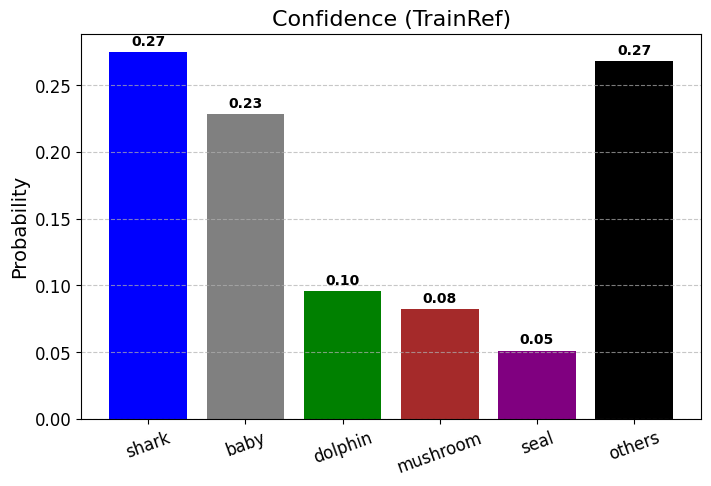

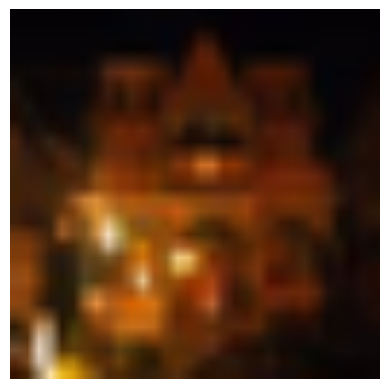

Label: house
Test ID: 171
house: 0.7815853357315063
castle: 0.10190504789352417
streetcar: 0.04076213389635086
bed: 0.009810893796384335
forest: 0.0041948468424379826


Label: beaver
Test ID: 172
beaver: 0.8182393312454224
shrew: 0.09780290722846985
lobster: 0.013610614463686943
mouse: 0.011470570228993893
crocodile: 0.01057693362236023


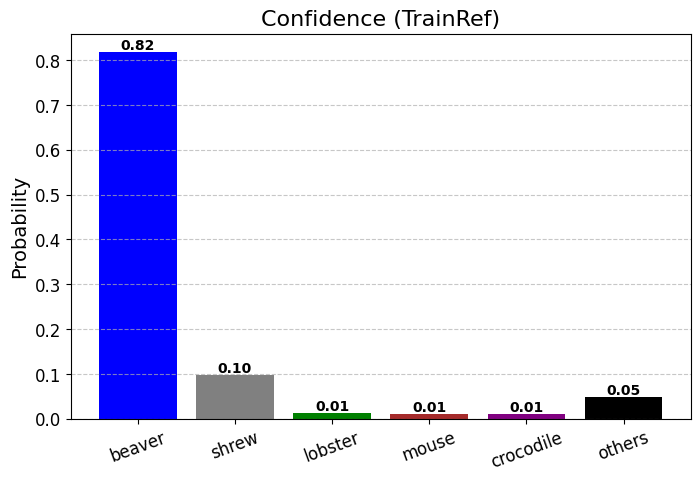

Label: lamp
Test ID: 186
lamp: 0.8320738077163696
table: 0.08761585503816605
bottle: 0.006515025161206722
cup: 0.006404193118214607
boy: 0.005612827371805906


Label: lobster
Test ID: 192
lobster: 0.9583046436309814
crab: 0.007848476059734821
sweet_pepper: 0.007083880715072155
poppy: 0.004167722072452307
snake: 0.0018453606171533465


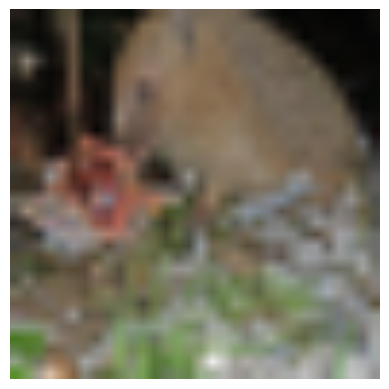

Label: porcupine
Test ID: 197
porcupine: 0.9509197473526001
leopard: 0.020182333886623383
possum: 0.004323666915297508
flatfish: 0.0037169454153627157
shrew: 0.002904940862208605


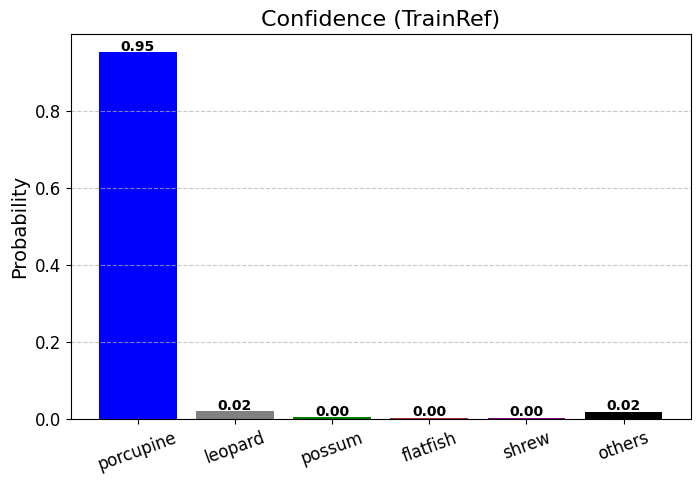

Label: lizard
Test ID: 206
lizard: 0.9970248937606812
shark: 0.0010782018071040511
crocodile: 0.0005937727401033044
lobster: 0.0003009539796039462
trout: 0.0001804510975489393


Label: turtle
Test ID: 209
turtle: 0.9941593408584595
bee: 0.0006838812842033803
ray: 0.0003345743170939386
crab: 0.00030584377236664295
lizard: 0.0002750989224296063


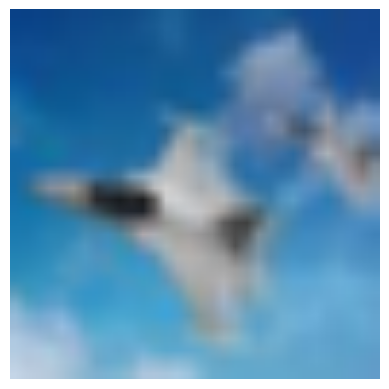

Label: shark
Test ID: 210
cloud: 0.4471900761127472
rocket: 0.36092182993888855
shark: 0.035462066531181335
sea: 0.026630712673068047
mountain: 0.02431574836373329


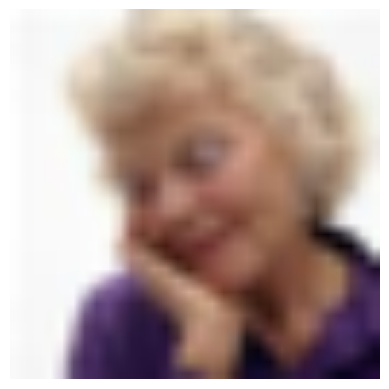

Label: woman
Test ID: 211
girl: 0.6013315320014954
woman: 0.36574587225914
baby: 0.014023072086274624
boy: 0.008992462418973446
man: 0.0049979062750935555


Label: pine_tree
Test ID: 215
willow_tree: 0.3294830024242401
pine_tree: 0.25389617681503296
maple_tree: 0.1411539763212204
oak_tree: 0.11105360835790634
forest: 0.09075973182916641


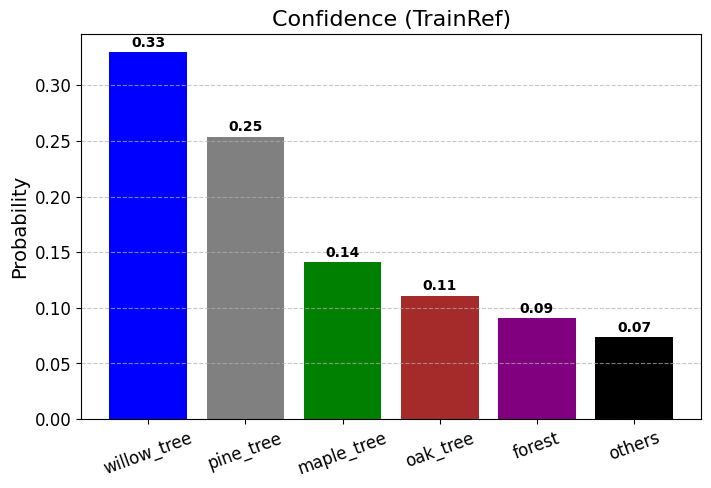

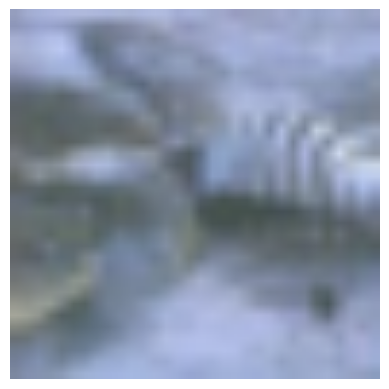

Label: crocodile
Test ID: 221
lizard: 0.25365740060806274
caterpillar: 0.2526647448539734
aquarium_fish: 0.134424090385437
trout: 0.09483152627944946
turtle: 0.04368896037340164


Label: apple
Test ID: 226
apple: 0.789984941482544
sweet_pepper: 0.1514078974723816
pear: 0.032653678208589554
lobster: 0.010405519045889378
poppy: 0.004002927336841822


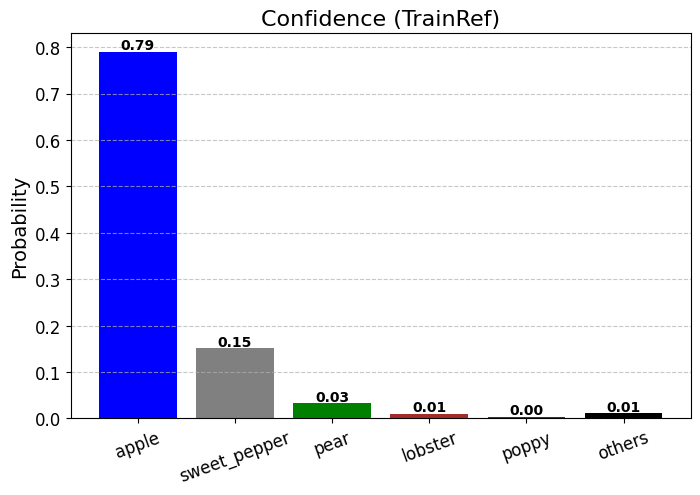

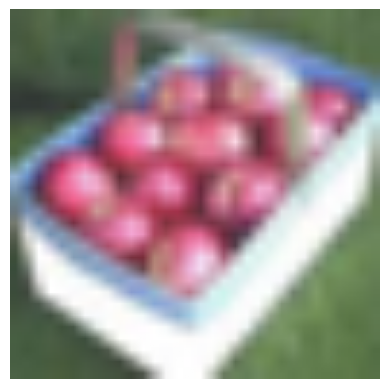

Label: apple
Test ID: 235
sweet_pepper: 0.29328253865242004
orange: 0.22975878417491913
keyboard: 0.143559530377388
pear: 0.14225256443023682
apple: 0.06266143172979355


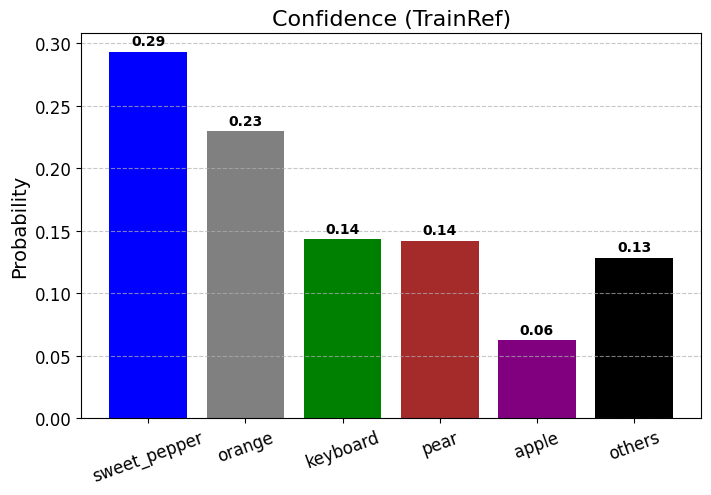

Label: beaver
Test ID: 248
beaver: 0.9983117580413818
shrew: 0.0006049282965250313
porcupine: 0.00031736266100779176
crocodile: 0.0002699508622754365
otter: 0.00010160733654629439


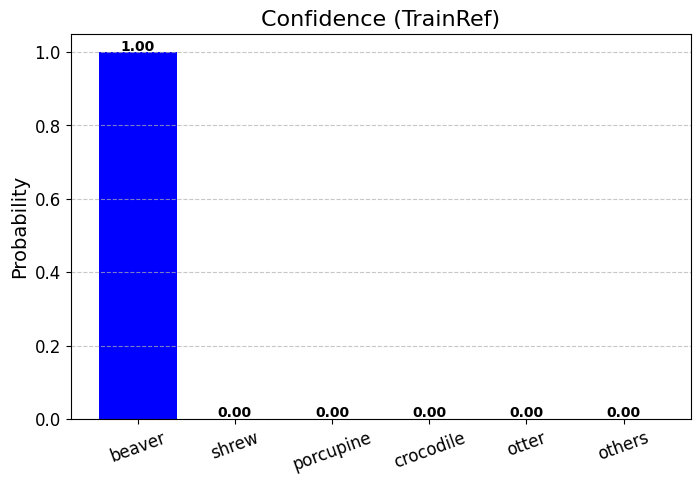

Label: hamster
Test ID: 252
hamster: 0.5855347514152527
seal: 0.18100082874298096
rabbit: 0.06912399083375931
mouse: 0.0311372559517622
otter: 0.02583409659564495


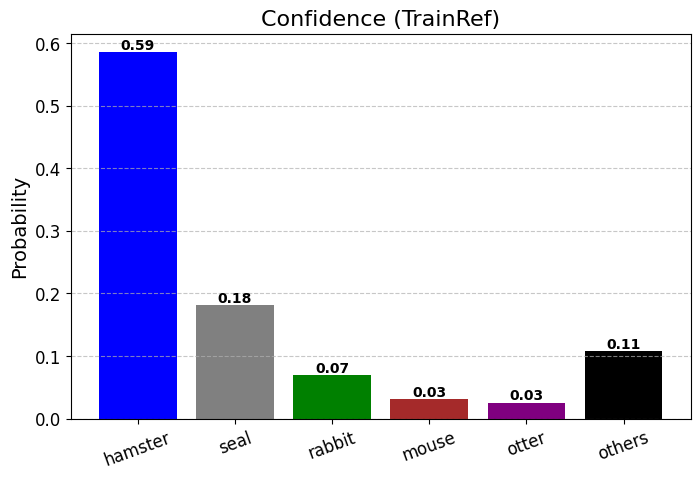

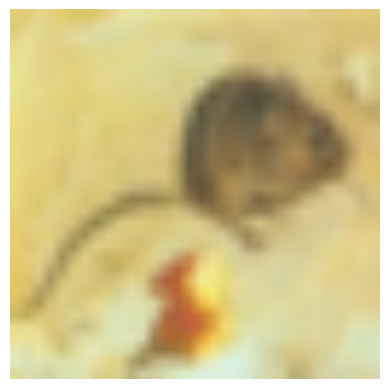

Label: mouse
Test ID: 254
mouse: 0.9884832501411438
rabbit: 0.004340125247836113
hamster: 0.0023184637539088726
shrew: 0.001536508440040052
cockroach: 0.0005193377728573978


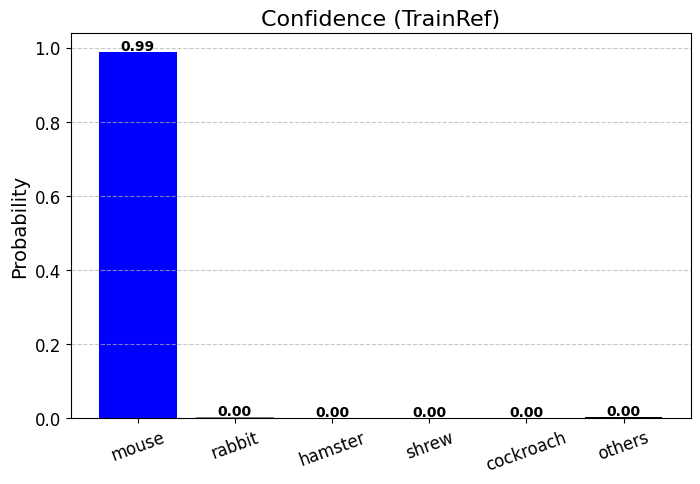

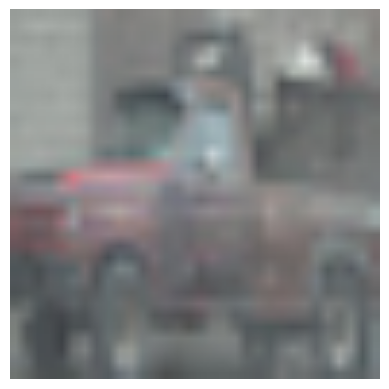

Label: pickup_truck
Test ID: 256
pickup_truck: 0.780724048614502
tractor: 0.035928040742874146
lawn_mower: 0.032854218035936356
bus: 0.027088133618235588
lamp: 0.012475517578423023


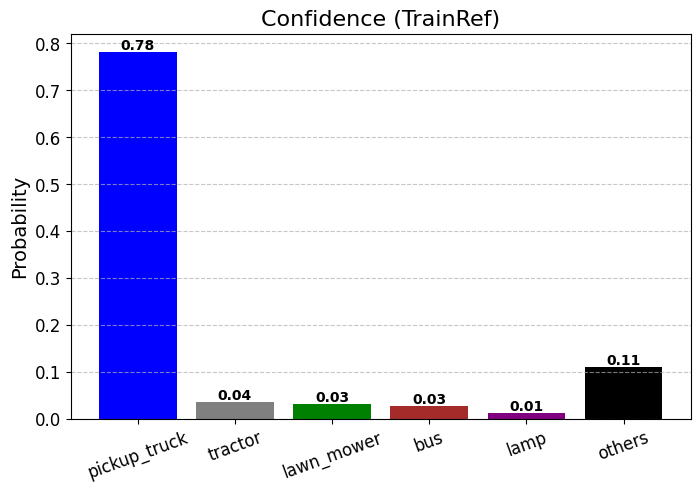

Label: otter
Test ID: 263
otter: 0.9473219513893127
beaver: 0.03787565231323242
crocodile: 0.0029259235598146915
sea: 0.002020374173298478
bear: 0.0012001307914033532


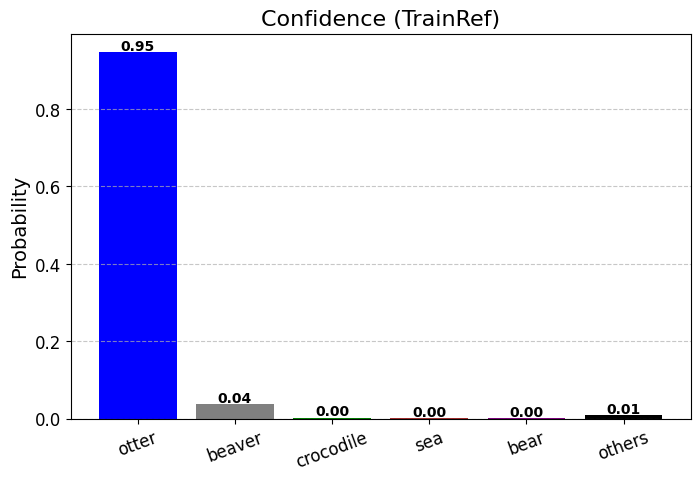

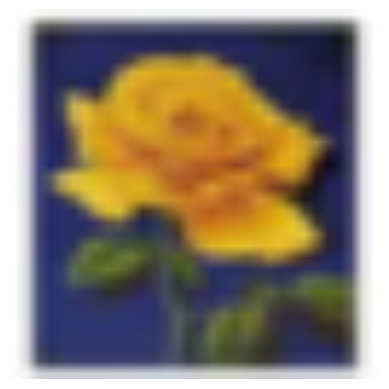

Label: rose
Test ID: 266
sunflower: 0.9231922626495361
poppy: 0.04090046510100365
rose: 0.024077339097857475
tulip: 0.010314512997865677
sweet_pepper: 0.0001945365802384913


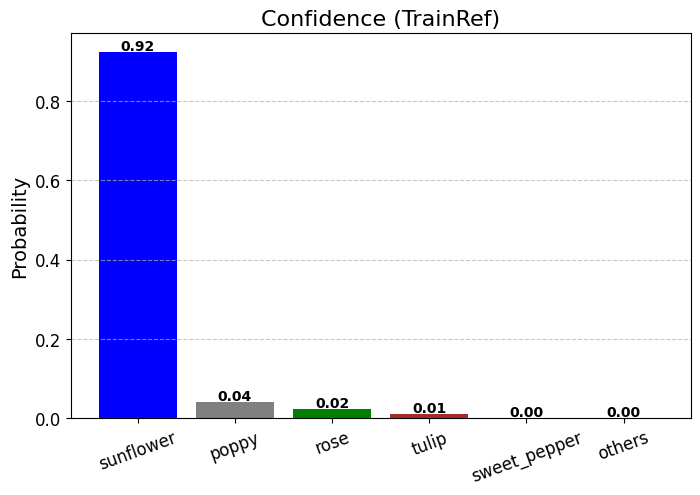

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch

disc_high_loss_ids = [1, 2, 5, 6, 10, 11, 23, 29, 31, 33, 35, 48, 49, 61, 62, 63, 64, 67, 71, 72, 74, 86, 87, 89, 92, 96, 98, 99, 116, 118, 127, 130, 134, 137, 143, 146, 148, 153, 158, 159, 164, 171, 172, 186, 192, 197, 206, 209, 210, 211, 215, 221, 226, 235, 248, 252, 254, 256, 263, 266, 267, 268, 277, 290, 291, 298, 303, 304, 310, 314, 315, 322, 329, 333, 334, 348, 349, 351, 352, 369, 374, 383, 385, 392, 397, 399, 402, 403, 406, 408, 409, 414, 416, 419, 420, 421, 422, 430, 431, 432]


# Define a threshold for small probability values
threshold = 0.0

classes = test_dataset.classes
for id in disc_high_loss_ids[40:60]:
    # Plot image
    img, label = test_dataset[id]
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axis
    plt.show()
    
    print('Label:', classes[label])
    

    
    
    # Get top 5 predictions
    probs = torch.nn.functional.softmax(torch.tensor(full_probs[id]), dim=0)
    
    # Apply thresholding: set small values to zero
    probs[probs < threshold] = 0

    # Re-normalize to sum to 1
    probs /= probs.sum()
    
    top5_prob, top5_cls = torch.topk(probs, 5)

    print('Test ID:', id)
    for i in range(5):
        print(f'{classes[top5_cls[i]]}: {top5_prob[i].item()}')



    # Extract top 5 soft label classes
    top_5_classes = [classes[top5_cls[i]] for i in range(5)]
    top_5_values = [top5_prob[i].item() for i in range(5)]

    # Compute "others" probability mass
    others_value = 1 - sum(top_5_values)
    others_value = max(0, others_value)  # Avoid negative values due to precision

    # Create labels and values for the bar plot
    labels = top_5_classes + ['others']
    values = top_5_values + [others_value]

    # Plot soft label distribution
    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color=['blue', 'gray', 'green', 'brown', 'purple', 'black'])

    # Labels and title
    plt.ylabel("Probability", fontsize=14)
    plt.title(f"Confidence (TrainRef)", fontsize=16)
    plt.xticks(fontsize=12, rotation=20)
    plt.yticks(fontsize=12)

    # Add grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Annotate bars
    for i, v in enumerate(values):
        plt.text(i, v + 0.005, f"{v:.2f}", ha='center', fontsize=10, fontweight='bold')

    # Indicate "others" category
    # plt.text(len(labels) - 1, values[-1] / 2, "Remaining classes", ha='center', fontsize=12, color='white', weight='bold')

    plt.show()

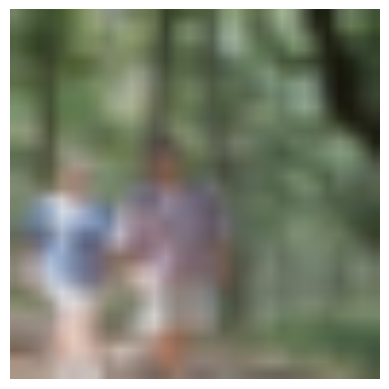

label: forest
Test ID: 1
squirrel: 0.29487907886505127
forest: 0.2614949941635132
willow_tree: 0.044550951570272446
elephant: 0.04410591349005699
pine_tree: 0.041117675602436066


label: seal
Test ID: 2
otter: 0.9696696400642395
seal: 0.02876020036637783
whale: 0.0004098636854905635
dolphin: 0.00036523191374726593
turtle: 0.00013263471191748977


label: tulip
Test ID: 5
orchid: 0.6415784358978271
tulip: 0.08785822987556458
caterpillar: 0.060082681477069855
spider: 0.05418584123253822
lizard: 0.032589491456747055


label: camel
Test ID: 6
camel: 0.24545703828334808
cattle: 0.08397042006254196
rabbit: 0.0658445805311203
elephant: 0.04961686581373215
kangaroo: 0.036592889577150345


label: sea
Test ID: 10
sea: 0.9081498384475708
bridge: 0.0689355880022049
cloud: 0.0030086555052548647
road: 0.0016598078655079007
forest: 0.0014884211122989655


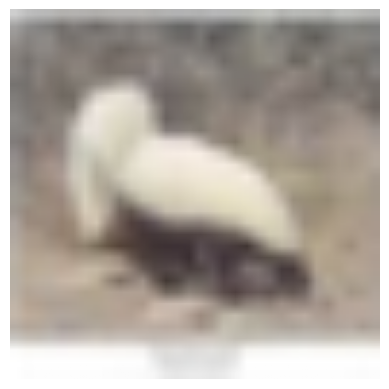

label: skunk
Test ID: 11
skunk: 0.9689452052116394
whale: 0.006238841917365789
porcupine: 0.005408845841884613
seal: 0.002061655977740884
bus: 0.0015287416754290462


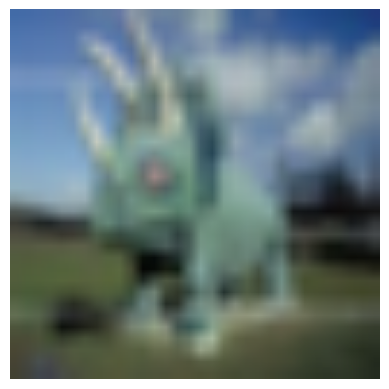

label: dinosaur
Test ID: 23
dinosaur: 0.7732822895050049
cattle: 0.025306832045316696
oak_tree: 0.02091240882873535
pine_tree: 0.019846666604280472
willow_tree: 0.017115097492933273


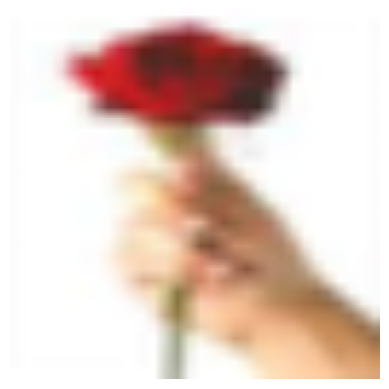

label: rose
Test ID: 29
rose: 0.9257199168205261
tulip: 0.04576624184846878
poppy: 0.021107297390699387
boy: 0.002885406371206045
beetle: 0.0006054664263501763


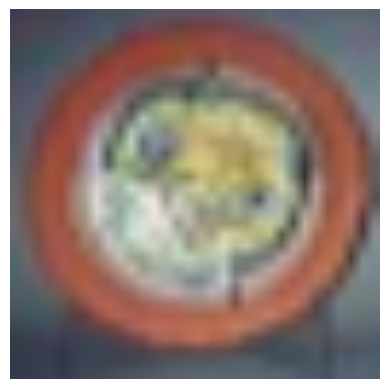

label: plate
Test ID: 31
clock: 0.5235066413879395
bowl: 0.26114729046821594
plate: 0.15330418944358826
cup: 0.03971695527434349
snake: 0.003435717895627022


label: turtle
Test ID: 33
shark: 0.8525522947311401
dolphin: 0.07371306419372559
ray: 0.032172828912734985
whale: 0.01916755922138691
turtle: 0.00876858364790678


label: shark
Test ID: 35
shark: 0.4352090656757355
dolphin: 0.22969946265220642
trout: 0.14210893213748932
whale: 0.11591819673776627
ray: 0.020361775532364845


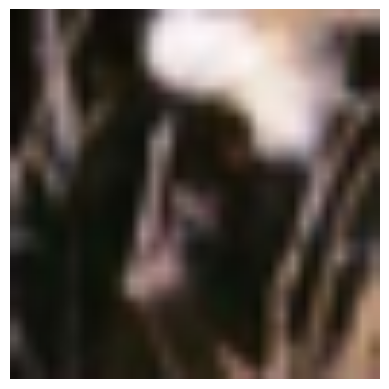

label: skunk
Test ID: 48
skunk: 0.913804292678833
bear: 0.024943428114056587
man: 0.006384280975908041
raccoon: 0.005921431351453066
bus: 0.004916162695735693


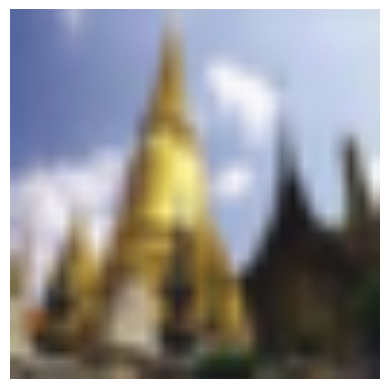

label: castle
Test ID: 49
castle: 0.7631797194480896
skyscraper: 0.15405333042144775
pine_tree: 0.0327073335647583
house: 0.013323304243385792
rocket: 0.008988702669739723


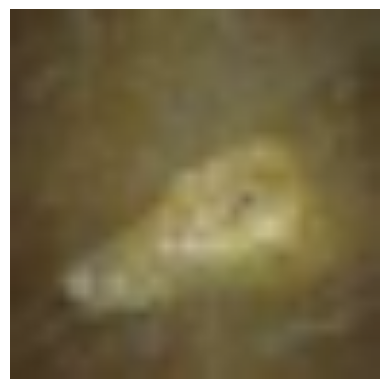

label: crocodile
Test ID: 61
crocodile: 0.711883008480072
ray: 0.0771334320306778
flatfish: 0.03763866052031517
porcupine: 0.0373799167573452
leopard: 0.020517701283097267


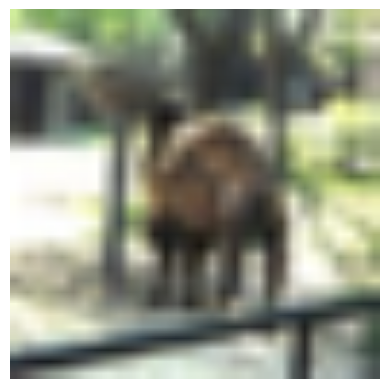

label: camel
Test ID: 62
elephant: 0.8408026099205017
cattle: 0.06918149441480637
camel: 0.027850832790136337
kangaroo: 0.025946471840143204
bear: 0.016597995534539223


label: rabbit
Test ID: 63
rabbit: 0.36084410548210144
otter: 0.16344118118286133
kangaroo: 0.11808996647596359
shrew: 0.09331793338060379
forest: 0.03211585059762001


label: beetle
Test ID: 64
beetle: 0.4857923984527588
aquarium_fish: 0.48346924781799316
hamster: 0.011786350980401039
poppy: 0.001899208058603108
apple: 0.001598117989487946


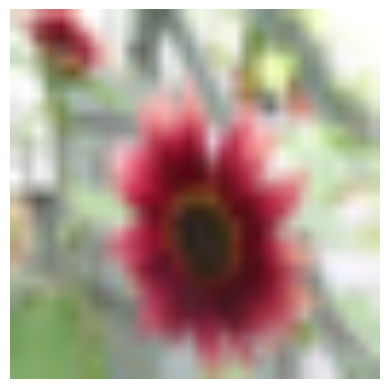

label: sunflower
Test ID: 67
sunflower: 0.9665692448616028
poppy: 0.007996841333806515
tulip: 0.005293132737278938
lawn_mower: 0.0011113175423815846
rose: 0.0009809096809476614


label: train
Test ID: 71
train: 0.6042280793190002
streetcar: 0.222305566072464
road: 0.07493909448385239
tractor: 0.011182892136275768
house: 0.009968617931008339


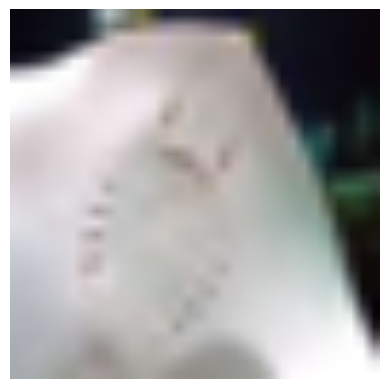

label: ray
Test ID: 72
ray: 0.6049279570579529
shark: 0.33608278632164
mouse: 0.019883573055267334
skyscraper: 0.005372907500714064
dolphin: 0.004771893378347158


In [18]:
disc_high_loss_ids = [1, 2, 5, 6, 10, 11, 23, 29, 31, 33, 35, 48, 49, 61, 62, 63, 64, 67, 71, 72, 74, 86, 87, 89, 92, 96, 98, 99, 116, 118, 127, 130, 134, 137, 143, 146, 148, 153, 158, 159, 164, 171, 172, 186, 192, 197, 206, 209, 210, 211, 215, 221, 226, 235, 248, 252, 254, 256, 263, 266, 267, 268, 277, 290, 291, 298, 303, 304, 310, 314, 315, 322, 329, 333, 334, 348, 349, 351, 352, 369, 374, 383, 385, 392, 397, 399, 402, 403, 406, 408, 409, 414, 416, 419, 420, 421, 422, 430, 431, 432]
classes = test_dataset.classes
for id in disc_high_loss_ids[:20]:
    # plot image
    img, label = test_dataset[id]
    # unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # not show axis
    plt.axis('off')
    plt.show()
    print('label:', classes[label])
    
    # print top 5 prediction
    probs = torch.nn.functional.softmax(torch.tensor(full_probs[id]), dim=0)
    top5_prob, top5_cls = torch.topk(probs, 5)
    print('Test ID:', id)
    for i in range(5):
        print(f'{classes[top5_cls[i]]}: {top5_prob[i].item()}')

In [12]:
from temperature_scaling import _ECELoss

full_probs = torch.cat(probs, dim=0).numpy()
targets = np.array([test_dataset.targets[i] for i in test_indices])
print(full_probs.shape, targets.shape)

ece_criterion = _ECELoss(n_bins=10)
ece_ = ece_criterion(torch.tensor(full_probs), torch.tensor(targets))
print(f'ECE: {ece_}')

# plot_calibration_curve(full_probs, targets, num_classes=100, n_bins=10)

(5000, 100) (5000,)
ECE: tensor([0.0014])


In [13]:
finetune_model.eval()

correct = 0
total = 0
test_loss = 0.0
probs = []
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = finetune_model(images)
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        
        probs.append(F.softmax(outputs, dim=1).detach().cpu())
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f" Testing Loss: {test_loss / len(test_loader):.4f}, Accuracy: {accuracy:.2f}%")

# y_prob = torch.cat(probs, dim=0)

full_probs = torch.cat(probs, dim=0).numpy()
targets = np.array([test_dataset.targets[i] for i in test_indices])

ece_criterion = _ECELoss(n_bins=10)
ece_ = ece_criterion(torch.tensor(full_probs), torch.tensor(targets))
print(f'ECE: {ece_}')

# plot_calibration_curve(full_probs, targets, num_classes=100, n_bins=10)

 Testing Loss: 4.6390, Accuracy: 0.86%


RuntimeError: The size of tensor a (5000) must match the size of tensor b (10000) at non-singleton dimension 0

In [14]:
full_probs = torch.cat(probs, dim=0).numpy()
targets = np.array([test_dataset.targets[i] for i in test_indices])

ece_criterion = _ECELoss(n_bins=10)
ece_ = ece_criterion(torch.tensor(full_probs), torch.tensor(targets))
print(f'ECE: {ece_}')

ECE: tensor([0.0007])


In [16]:

def compute_ece(y_true, y_prob, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE).
    
    Parameters:
        y_true (numpy array): True binary labels (0 or 1).
        y_prob (numpy array): Predicted probabilities for the positive class.
        n_bins (int): Number of bins to use for calibration.
    
    Returns:
        float: Expected Calibration Error (ECE).
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    n = len(y_true)  # Total number of samples

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Select samples that fall into the current bin
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        bin_size = np.sum(in_bin)
        
        if bin_size > 0:
            # Compute accuracy and confidence for this bin
            accuracy = np.mean(y_true[in_bin])  # Fraction of positives
            confidence = np.mean(y_prob[in_bin])  # Mean predicted probability
            
            # Weighted absolute difference between accuracy and confidence
            ece += (bin_size / n) * abs(accuracy - confidence)
    
    return ece


cls_id: 4, prob_true: 9, prob_pred: 9
cls_id: 11, prob_true: 9, prob_pred: 9
Mean ECE: 0.0018003622960024845


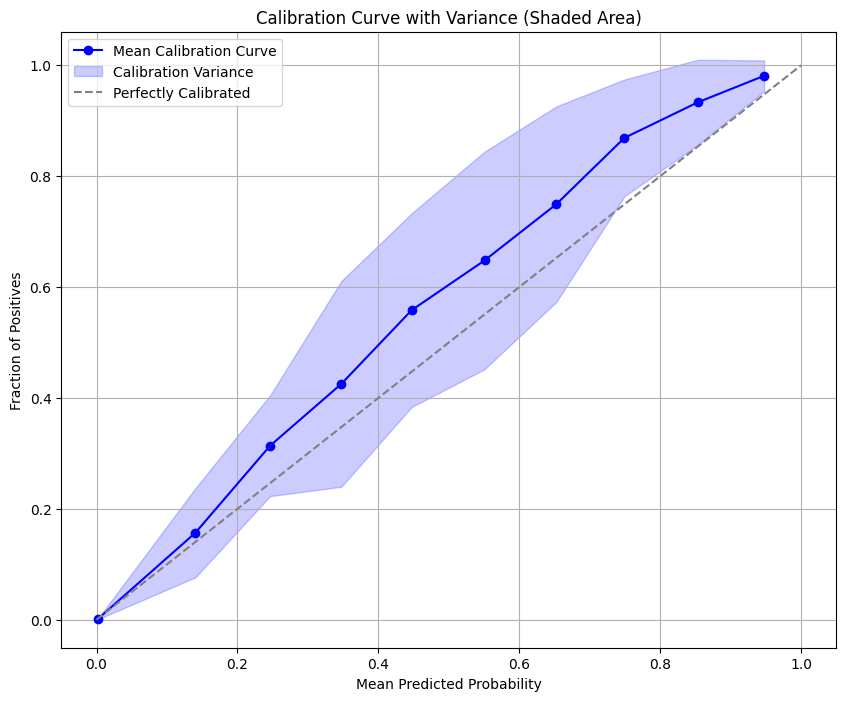

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.calibration import calibration_curve
# from sklearn.metrics import brier_score_loss

# cls_id = 1
# num_classes = 100
# prob_true_all = np.zeros(10)
# prob_pred_all = np.zeros(10)
# ece = []

# insp_clss = list(range(num_classes))
# insp_clss = [1,2]


# for cls_id in insp_clss:
#     y_prob = np.array(full_probs[:, cls_id])
#     y_true = np.array(targets == cls_id)
#     # Compute calibration curve
#     prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
#     if prob_true.shape[0] != 10 or prob_pred.shape[0] != 10:
#         print(f'cls_id: {cls_id}, prob_true: {prob_true.shape[0]}, prob_pred: {prob_pred.shape[0]}')
#         continue
#     prob_true_all += prob_true
#     prob_pred_all += prob_pred
    
#     # Compute Expected Calibration Error (ECE)
#     ece.append(compute_ece(y_true, y_prob, n_bins=10))
    
# prob_true = prob_true_all / len(ece)
# prob_pred = prob_pred_all / len(ece)

# print(f'Mean ECE: {np.mean(ece)}')

# # Plot calibration curve
# plt.figure(figsize=(10, 8))
# plt.plot(prob_pred, prob_true, marker='o', label='Model')
# plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
# plt.xlabel('Mean Predicted Probability')
# plt.ylabel('Fraction of Positives')
# plt.title('Calibration Curve')
# plt.legend()
# plt.grid()
# plt.show()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

cls_id = 1
num_classes = 100
prob_true_all = []
prob_pred_all = []
ece = []

# insp_clss = list(range(num_classes))  # Inspect all classes
# insp_clss = [1, 2]  # Inspect specific classes
insp_clss = list(range(30))

for cls_id in insp_clss:
    y_prob = np.array(full_probs[:, cls_id])
    y_true = np.array(targets == cls_id)

    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

    if prob_true.shape[0] != 10 or prob_pred.shape[0] != 10:
        print(f'cls_id: {cls_id}, prob_true: {prob_true.shape[0]}, prob_pred: {prob_pred.shape[0]}')
        continue
    
    prob_true_all.append(prob_true)
    prob_pred_all.append(prob_pred)

    # Compute Expected Calibration Error (ECE)
    ece.append(compute_ece(y_true, y_prob, n_bins=10))

# Convert lists to numpy arrays
prob_true_all = np.array(prob_true_all)
prob_pred_all = np.array(prob_pred_all)

# Compute mean and standard deviation for each bin
prob_true_mean = np.mean(prob_true_all, axis=0)
prob_pred_mean = np.mean(prob_pred_all, axis=0)
prob_true_std = np.std(prob_true_all, axis=0)

print(f'Mean ECE: {np.mean(ece)}')

# Plot calibration curve with shaded variance area
plt.figure(figsize=(10, 8))
plt.plot(prob_pred_mean, prob_true_mean, marker='o', label="Mean Calibration Curve", color="blue")
plt.fill_between(prob_pred_mean, prob_true_mean - prob_true_std, prob_true_mean + prob_true_std, color="blue", alpha=0.2, label="Calibration Variance")
plt.plot([0, 1], [0, 1], linestyle='--', color="gray", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve with Variance (Shaded Area)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss


# Compute calibration curve
y_test = img_test_dataset.targets
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(10, 8))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()